In [82]:
import requests
import json
import pandas as pd
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from os import listdir
import plotly.express as px
import secret
import re
import numpy as np

### Pulling down from new API

##### It works, but it is quite slow. I will have to convert it to asynchronous to that the call can be faster

In [66]:
makes = [
    "acura",
    # "buick",
    # "cadillac",
    # "chevrolet",
    # "chrysler",
    # "gmc",
    # "ford",
    # "honda",
    # "infiniti",
    # "jeep",
    # "kia",
    # "mitsubishi",
    # "nissan",
    # "porsche",
    # "ram",
    # "subaru",
    # "toyota",
    # "volkswagen",
    # "volvo",
    # "alfa_romeo",
    # "rolls_royce",
    # "mini",
    # "fiat",
    # "aston_martin",
    # "maserati",
    # "bmw",
    # "mercedes_benz"
]


'''
Pull down the listings from the date provided from one week earlier
'''
def pull_down_weekly_listings(date) -> pd.DataFrame:
    
    url = secret.API_URL
    payload = ""
    headers = {"x-api-key": secret.API_KEY}
    
    df = pd.DataFrame()
    results = []
    
    
    for i in range(31):
        
        day = (date - timedelta(days=i)).date().isoformat()
        
        for make in makes:
    
            querystring = {"make":make,"date":day}


            response = requests.request("GET", url, data=payload, headers=headers, params=querystring)

            df_temp = pd.read_json(response.text)
            
            df = pd.concat([df, df_temp])
            
            

    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Year'].astype(str)
    
    return df
    

df = pull_down_weekly_listings(datetime.now())  
df.info()  

# runtime is 8.6 seconds. Very bad.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 960 entries, 0 to 34
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Rating Count  960 non-null    int64         
 1   Date          960 non-null    datetime64[ns]
 2   Year          960 non-null    object        
 3   Mileage       960 non-null    int64         
 4   Price         960 non-null    int64         
 5   Dealer Name   960 non-null    object        
 6   ID            960 non-null    object        
 7   Make          960 non-null    object        
 8   Rating        960 non-null    float64       
 9   Date-Make     960 non-null    object        
 10  Name          960 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 90.0+ KB


In [67]:
import aiohttp
import asyncio
import json

results = []

'''
Pull down the listings from the date provided from one week earlier
'''
def pull_down_weekly_listings(session, make, date):
    NUM_DAYS = 31
    
  
    tasks = []
    
    for i in range(NUM_DAYS):

        day = (date - timedelta(days=i)).date().isoformat()

        url = "{}?make={}&date={}".format(secret.API_URL, make, str(day))

        querystring = {"make":make,"date":day}

        # params=querystring,

        tasks.append(session.get(url))


    # response = session.get("GET", url, data=payload, headers=headers, params=querystring)
    
    return tasks



async def gather_results():

    headers = {"x-api-key": secret.API_KEY}

    async with aiohttp.ClientSession(headers=headers) as session:
        tasks = pull_down_weekly_listings(session, "acura", datetime.now())
        responses = await asyncio.gather(*tasks)
        for response in responses:
            results.append(await response.json())

asyncio.run(gather_results())

In [68]:
df = pd.DataFrame()

for i in results:
    temp_df = pd.read_json(json.dumps(i))
    df = pd.concat([df, temp_df])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 960 entries, 0 to 34
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Rating Count  960 non-null    int64         
 1   Date          960 non-null    datetime64[ns]
 2   Year          960 non-null    int64         
 3   Mileage       960 non-null    int64         
 4   Price         960 non-null    int64         
 5   Dealer Name   960 non-null    object        
 6   ID            960 non-null    object        
 7   Make          960 non-null    object        
 8   Rating        960 non-null    float64       
 9   Date-Make     960 non-null    object        
 10  Name          960 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 90.0+ KB


In [77]:
df['Date'].dt.isocalendar().week.value_counts()

37    235
34    219
36    214
35    203
38     54
33     35
Name: week, dtype: Int64

In [86]:
df['Date'].dt.isocalendar().year

0     2022
1     2022
2     2022
3     2022
4     2022
      ... 
30    2022
31    2022
32    2022
33    2022
34    2022
Name: year, Length: 960, dtype: UInt32

In [91]:
df.columns

Index(['Rating Count', 'Date', 'Year', 'Mileage', 'Price', 'Dealer Name', 'ID',
       'Make', 'Rating', 'Date-Make', 'Name'],
      dtype='object')

In [94]:
d = "2022-W37"
r = datetime.strptime(d + '-1', "%Y-W%W-%w")

def get_start_day(week_number, year):

    day_string = "{}-W{}".format(str(year), str(week_number))
    return datetime.strptime(day_string + '-1', "%Y-W%W-%w")

df.apply(lambda x: get_start_day(x['Date'].isocalendar().week, x['Date'].year), axis = 1).value_counts()

2022-09-12    235
2022-08-22    219
2022-09-05    214
2022-08-29    203
2022-09-19     54
2022-08-15     35
dtype: int64

In [95]:
df['Starting Monday'] = df.apply(lambda x: get_start_day(x['Date'].isocalendar().week, x['Date'].year), axis = 1)


<AxesSubplot:xlabel='Starting Monday', ylabel='Price'>

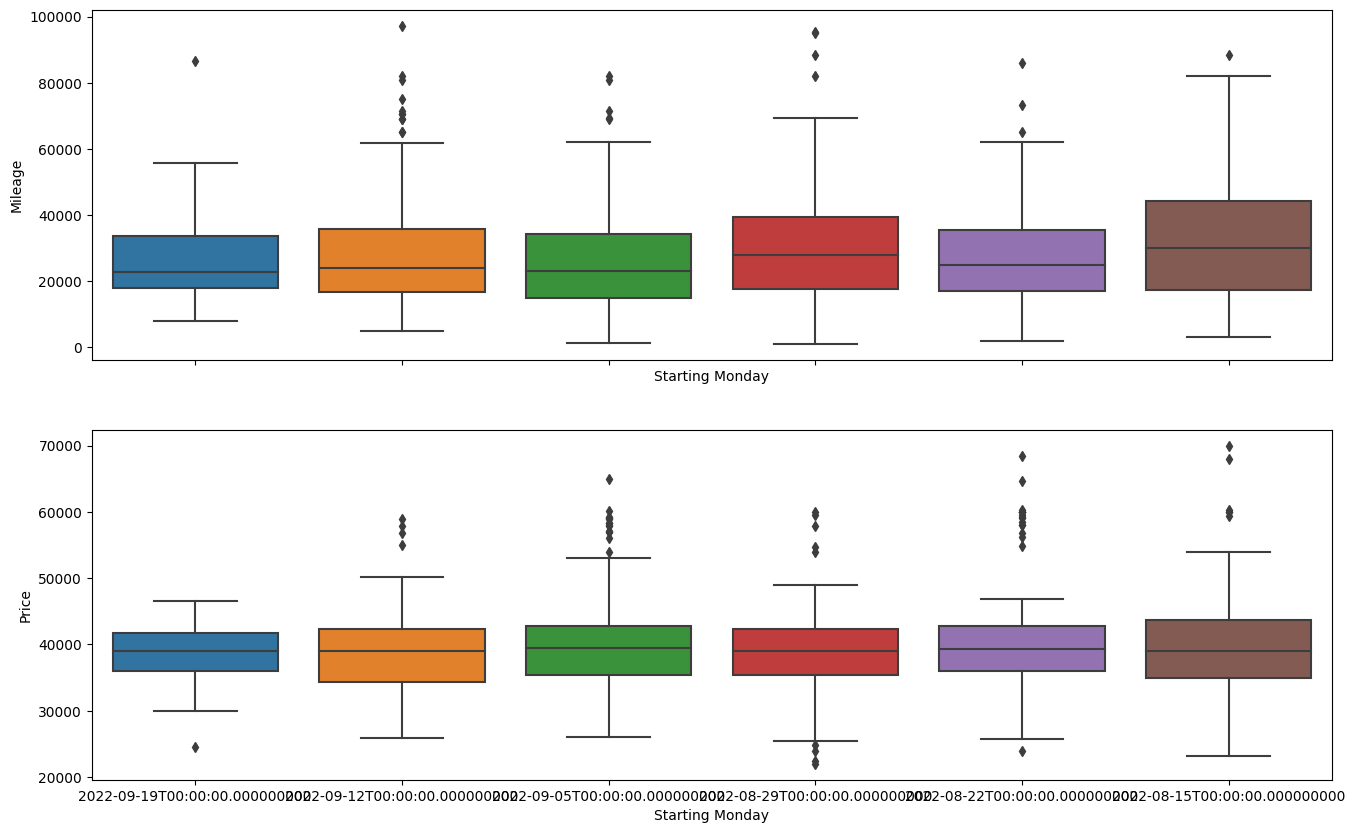

In [105]:
fig, ax = plt.subplots(2, 1, figsize = (16,10), sharex=True)

sns.boxplot(data = df, x = "Starting Monday", y = "Mileage", ax=ax[0])
sns.boxplot(data = df, x = "Starting Monday", y = "Price", ax=ax[1])
# sns.boxplot(data = df, x = "Starting Monday", y = "Mileage", ax=ax[0])

<AxesSubplot:xlabel='Starting Monday'>

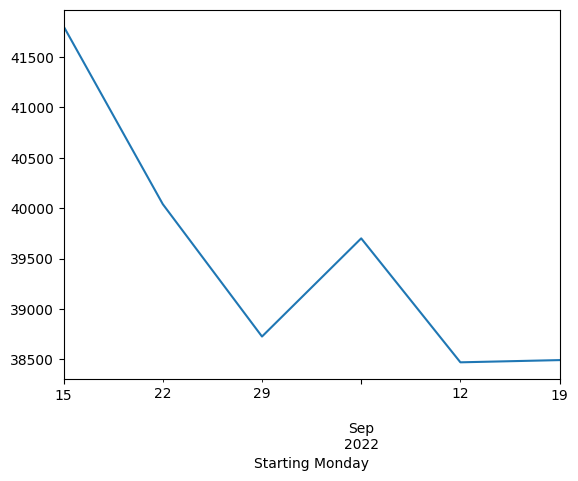

In [108]:
df.groupby('Starting Monday')['Price'].mean().plot()

<AxesSubplot:xlabel='Starting Monday'>

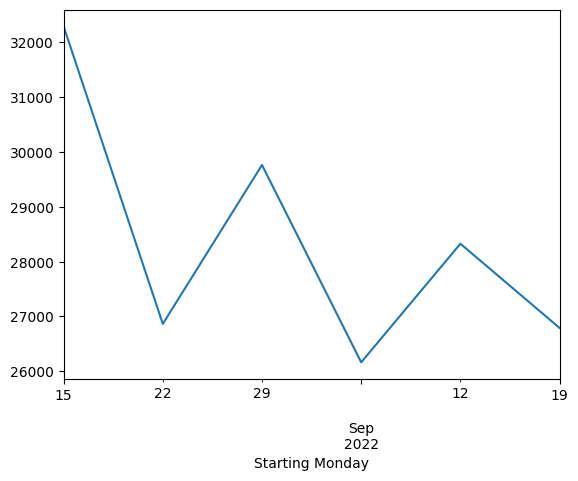

In [109]:
df.groupby('Starting Monday')['Mileage'].mean().plot()

<AxesSubplot:>

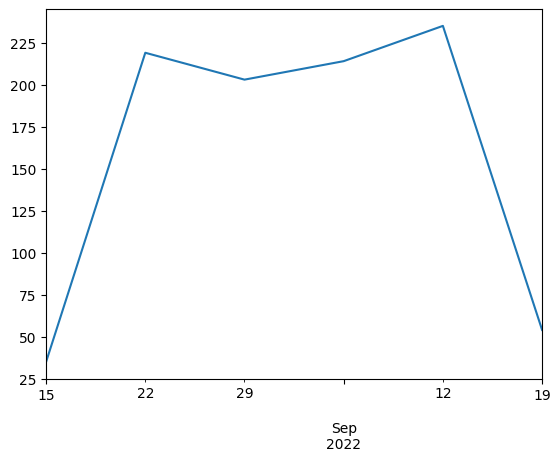

In [110]:
df['Starting Monday'].value_counts().sort_index().plot()

In [48]:
df['Name'].value_counts()

2020 Acura MDX 3.5L w/Technology Package                 68
2019 Acura MDX 3.5L                                      38
2020 Acura MDX 3.5L                                      37
2020 Acura TLX FWD                                       28
2020 Acura RDX Technology Package                        27
                                                         ..
2020 Acura ILX TECHNOLOGY&A-SPEC PACKAGES                 1
2019 Acura TLX V6 Technology & A-Spec                     1
2019 Acura MDX Sport Hybrid 3.0L w/Technology Package     1
2019 Acura MDX                                            1
2022 Acura MDX w/A-Spec Package                           1
Name: Name, Length: 69, dtype: int64

<AxesSubplot:>

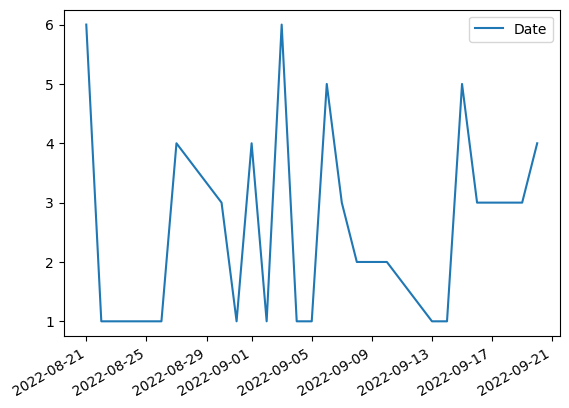

In [69]:
df_listing_count = pd.DataFrame(df[df['Name'] == '2020 Acura RDX Technology Package']['Date'].value_counts().sort_index())
df_listing_count.plot()

<AxesSubplot:xlabel='Date'>

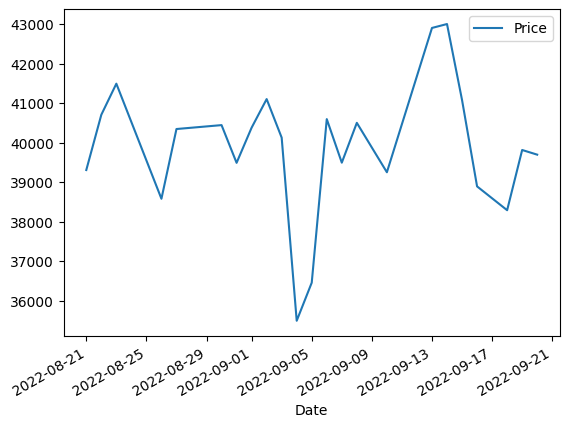

In [72]:
df_average_price = pd.DataFrame(df[df['Name'] == '2020 Acura RDX Technology Package'].groupby('Date')['Price'].mean().sort_index())
df_average_price.plot()

<AxesSubplot:xlabel='Date'>

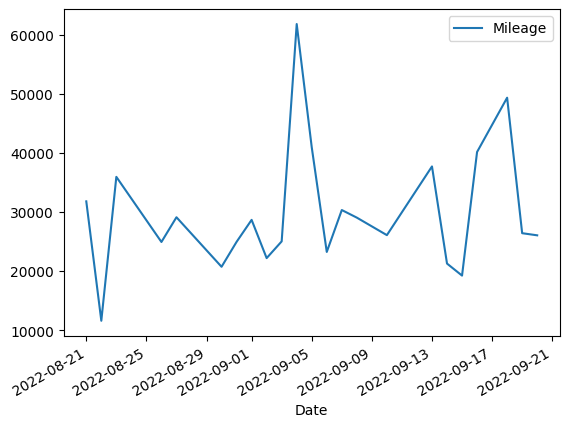

In [74]:
df_average_mileage = pd.DataFrame(df[df['Name'] == '2020 Acura RDX Technology Package'].groupby('Date')['Mileage'].mean().sort_index())
df_average_mileage.plot()

##### Grab Last Week's Listings

In [5]:
df_last_week = pull_down_weekly_listings(datetime.now()- timedelta(days=7))  
df_last_week.info()  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415 entries, 0 to 29
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Rating Count  415 non-null    int64         
 1   Date          415 non-null    datetime64[ns]
 2   Year          415 non-null    object        
 3   Mileage       415 non-null    int64         
 4   Price         415 non-null    int64         
 5   Dealer Name   415 non-null    object        
 6   ID            415 non-null    object        
 7   Make          415 non-null    object        
 8   Rating        415 non-null    float64       
 9   Date-Make     415 non-null    object        
 10  Name          415 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 38.9+ KB


In [9]:
df['Name'].value_counts()

2020 Acura MDX 3.5L                         20
2020 Acura MDX 3.5L w/Technology Package    16
2019 Acura MDX 3.5L w/Technology Package    15
2020 Acura TLX FWD                          15
2021 Acura TLX Technology                   12
2019 Acura MDX 3.5L                         12
2019 Acura RDX Technology Package           11
2019 Acura RDX Base                         10
2020 Acura TLX V6 w/Technology Package      10
2020 Acura RDX Technology Package            8
2020 Acura RDX Advance Package               6
2021 Acura RDX w/Technology Package          6
2020 Acura TLX Technology                    5
2021 Acura RDX A-Spec                        5
2019 Acura RDX A-Spec                        4
2022 Acura MDX A-Spec                        4
2021 Acura RDX Technology Package            4
2022 Acura MDX w/Advance Package             4
2021 Acura TLX Tech                          3
2020 Acura RDX Base                          3
2019 Acura RDX                               3
2022 Acura MD

### Say a user chooses '2020 Acura MDX 3.5L'

In [ ]:
df_last_week[df_last_week['Name'] == '2020 Acura MDX 3.5L']['Mileage']

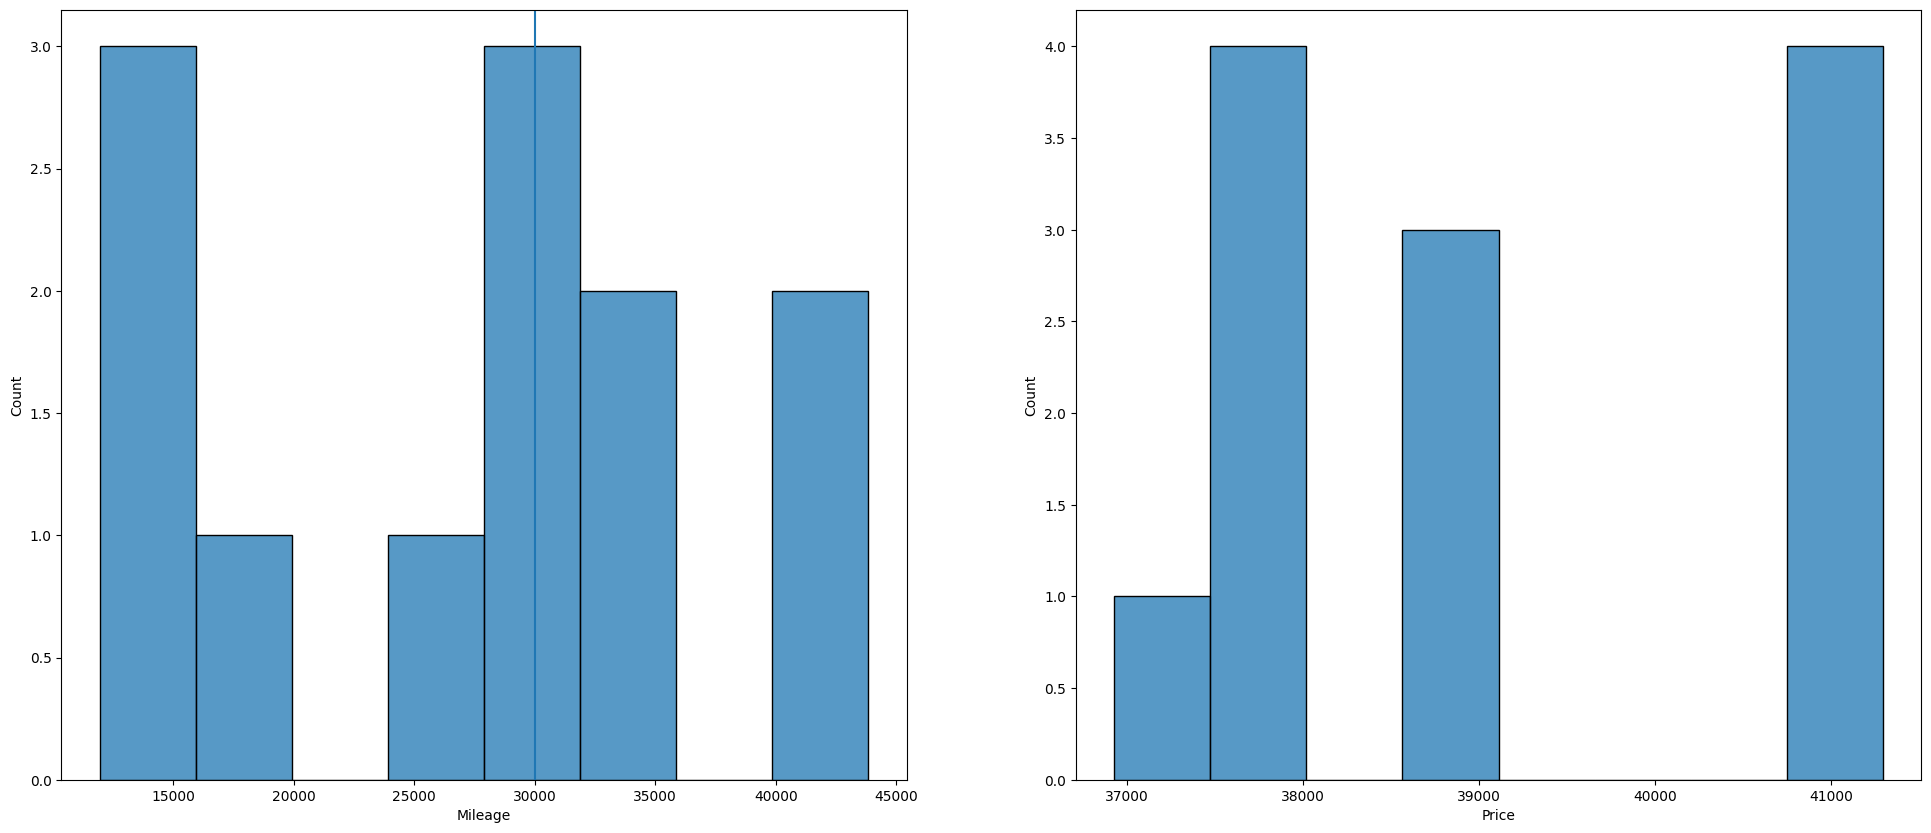

In [30]:
def hist_plot(make, df_hist):
    
    fig, ax = plt.subplots(1,2, figsize=(24,10))

    sns.histplot(
        data = df_hist[df_hist['Name'] == make]['Mileage'],
        bins = 8,
        ax = ax[0]

    )


    sns.histplot(
        data = df_hist[df_hist['Name'] == make]['Price'],
        bins = 8,
        ax = ax[1]
    )


hist_plot('2020 Acura MDX 3.5L', df_last_week)

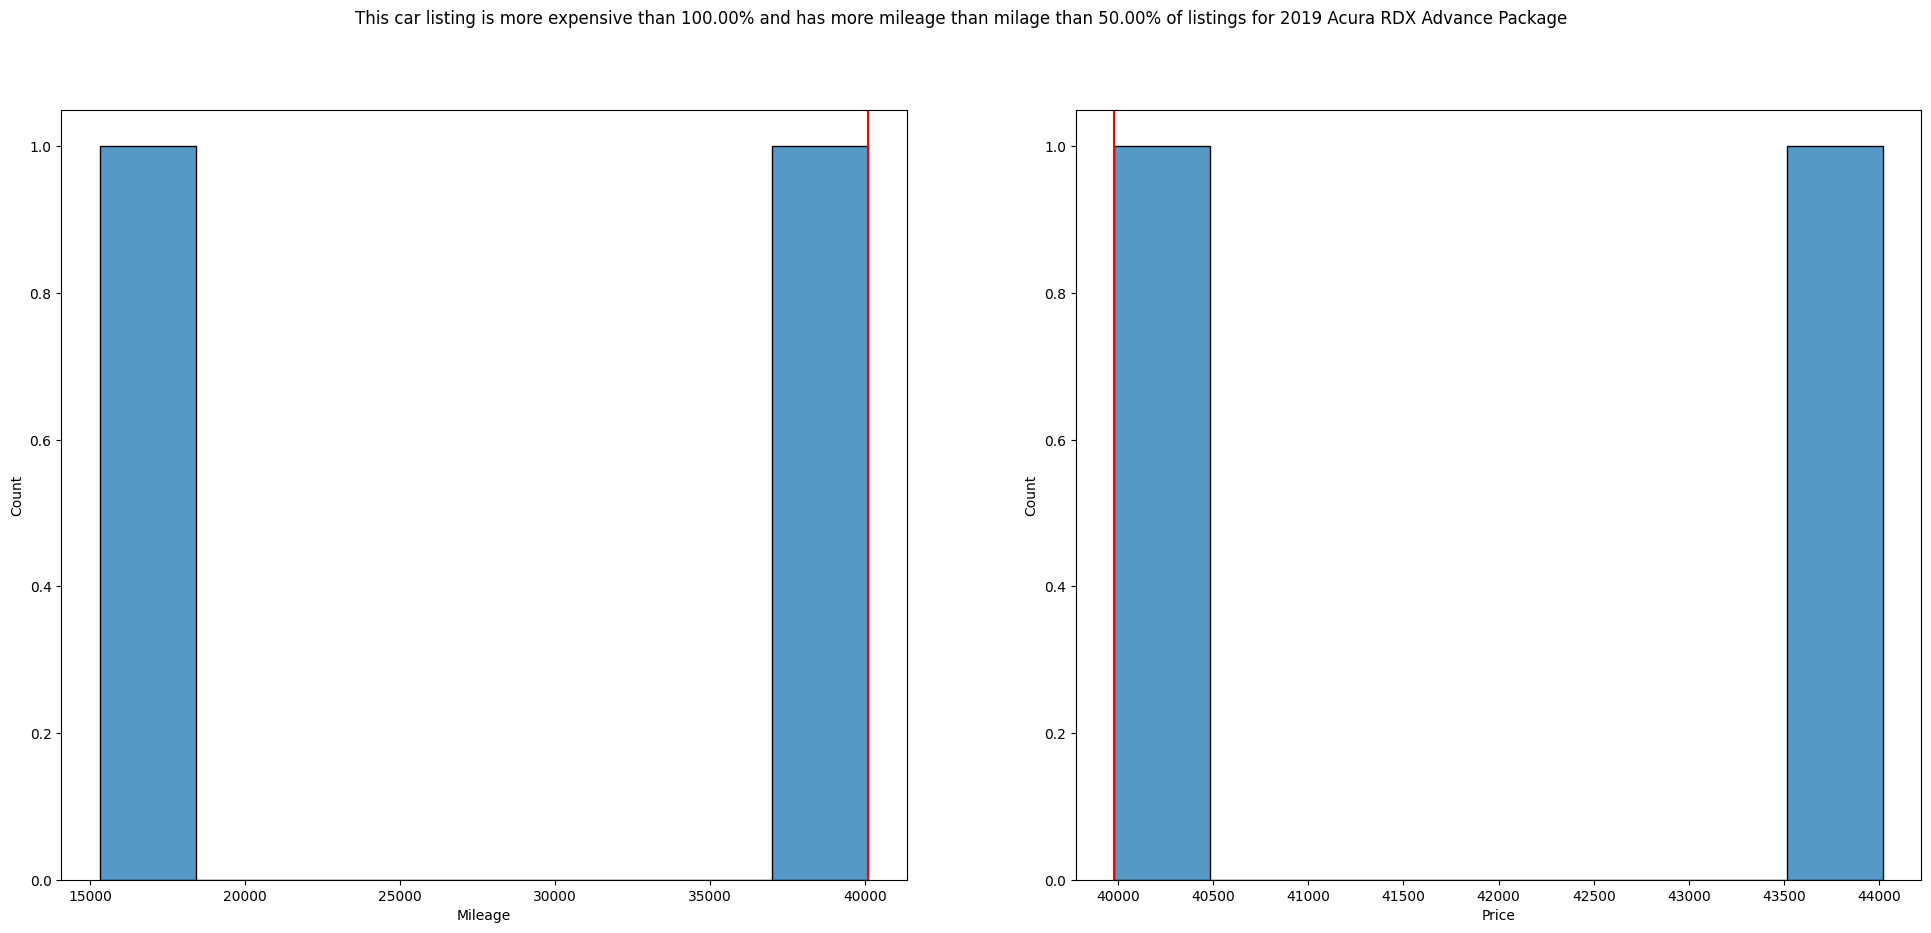

In [60]:
def hist_plot_with_listing(df_hist, row):

    record = df_hist.iloc[row]
    fig, ax = plt.subplots(1,2, figsize=(24,10))

    df_hist_filtered = df_hist[df_hist['Name'] == record['Name']]

    sns.histplot(
        data = df_hist_filtered['Mileage'],
        bins = 8,
        ax = ax[0]
    )


    sns.histplot(
        data = df_hist_filtered['Price'],
        bins = 8,
        ax = ax[1]
    )

    ax[0].axvline(record['Mileage'], color = 'red', linewidth = 1.5)
    ax[1].axvline(record['Price'], color = 'red', linewidth = 1.5)

    fig.suptitle(
        'This car listing is more expensive than {:.2f}% and has more mileage than milage than {:.2f}% of listings for {}' \
            .format(
                stats.percentileofscore(df_hist_filtered['Mileage'], record['Mileage'], kind = 'weak'), 
                stats.percentileofscore(df_hist_filtered['Price'], record['Price'], kind = 'weak'),
                record['Name'])
    )

    plt.show()

hist_plot_with_listing(df_last_week, 3)

##### A user can select one table item